# Random Florest para predição de Doença Cardíaca

## Autor
Lucas Gabriel Bezerra - 180125770

GitHub: lucasgbezerra

## Objetivo

A aula 6 do fastai apresenta as arvóres de decisão e as florestas randômicas. Esses conceitos são formas rápidas de criar um modelo de aprendizado de máquina que pode ser usado pra classificação, para regressão e ainda para analíse explorátoria dos dados.

Dessa forma, busquei entender melhor os conceitos para aplicar em um modelo para predição de falhas do coração.


## Motivação

Aplicar o conceito de Floresta Randômica para criar um modelo capaz de predizer Falhas do coração, evento comumente causado por doenças cardiovasculares.

As doenças cardiovasculares (DCVs) são a causa número 1 de morte no mundo, levando cerca de 17,9 milhões de vidas a cada ano, o que representa 31% de todas as mortes em todo o mundo.

Importando o conjunto de dados presente no [link]('https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction') 

## Preparação e análise dos dados

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv
/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


In [2]:
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')

Os dados podem ser visualizados na célula abaixo.

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Os dados são distribuidos em 12 colunas e 918 linhas, as colunas representam os atributos e são as seguintes.
* Age: idade do paciente em anos
* Sex: sexo do paciente M (Masculino), F(Feminino)
* ChestPainType: tipo de dor no peito TA(Angina Típica), ATA(Angina Atípica) NAP (Dor Não Anginosa) e ASY (Assintomática)
* RestingBP: pressão arterial em repouso (mm/Hg)
* Cholesterol: colesterol sérico (mm/dl)
* FastingBS: açúcar no sangue em jejum: 1 (FastingBS > 120 mg/dl), 0(FastingBS <= 120 mg/dl)
* RestingECG: resultados do eletrocardiograma em repouso, podemdo ser: Normal, ST (com anormalidade da onda ST-T, inversões da onda T e/ou elevação ou depressão do ST > 0,05 mV), HVE(mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Este's)
* MaxHR: frequência cardíaca máxima alcançada.
* ExerciseAngina: angina induzida por exercício, sendo Y (Sim), N (Não).
* Oldpeak: oldpeak = ST (Valor numérico medido na depressão)
* ST_Slope: a inclinação do segmento ST do exercício de pico, podendo ser: Up (ascendente), Flat (plano), Down (descendente)
* HeartDisease: tag onde 1 (paciente tem doença cardíaca) 0(normal)

In [5]:
modes = df.mode().iloc[0]
modes

Age                   54
Sex                    M
ChestPainType        ASY
RestingBP            120
Cholesterol            0
FastingBS              0
RestingECG        Normal
MaxHR                150
ExerciseAngina         N
Oldpeak              0.0
ST_Slope            Flat
HeartDisease           1
Name: 0, dtype: object

O método *mode()* retorna os valores mais repetidos em cada coluna. Isso pode ser utilizado para preenchimento de dados vazios.
Nesse artigo serão utilizados como valores padrões no deploy.

In [6]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Podemos perceber que nenhuma das linhas possui qualquer valor nulo.

Agora, vamos observar como os valores númericos estão distribuidos em cada coluna.

Além disso, vamos salvar as colunas númericas na variável *conts* que será utilizada posteriormente

In [7]:
conts = df.describe(include=(np.number)).columns.tolist()
df.describe(include=(np.number))

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Agora, vamos observar como os valores do tipo object estão distribuidos em cada coluna. 

As colunas categóricas também serão salvas para uso posterior

In [8]:
cats = df.describe(include=[object]).columns.tolist()
df.describe(include=[object])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


Por fim, salvaremos a coluna que representa o dado que dejesamos prever

In [9]:
conts.remove('HeartDisease')
dependent = 'HeartDisease'

### Analisando os dados graficamente

Primeiramente, vamos analisar a proporção dos sexos (masculinos e femininos) presentes no dataset e como o sexo se relaciona com as doenças cardiacas.

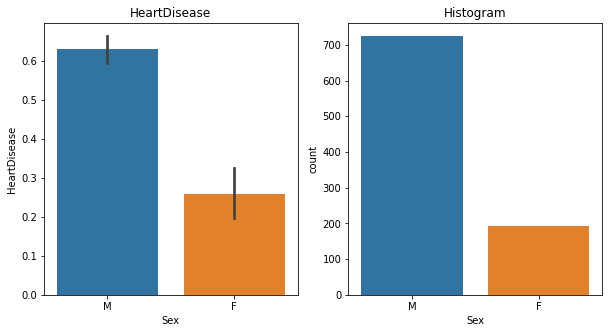

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,2, figsize=(10,5))
sns.barplot(data=df, y=dependent, x="Sex", ax=axs[0]).set(title=dependent)
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

Podemos notar que o dataset possui sua maioria de dados sobre pessoas do sexo masculino. O Gráfico de HeartDisease mostra que 60% dos homens possuem doença cardiaca, enquanto só 25% das mulheres. Isso mostra uma predisposição para homens terem doença cardiaca.

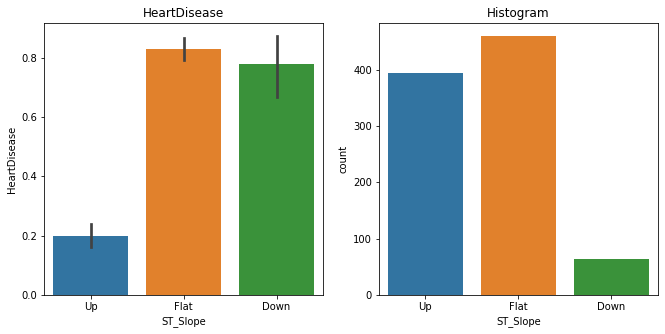

In [11]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dependent, x="ST_Slope", ax=axs[0]).set(title="HeartDisease")
sns.countplot(data=df, x="ST_Slope", ax=axs[1]).set(title="Histogram");

Outro dado a ser analisado é o ST_Slope(a inclinação do segmento ST do exercício de pico, podendo ser: Up (ascendente), Flat (plano), Down (descendente)).

Podemos ver que os esse atributo tem uma distribuição proxima para Up e Flat, mas poucos casos para Down. Quando relacionado as doenças cardiacas podemos notar que cerca de 80% das pessoas que tiveram o ST_Slope avaliados como UP não possuem doença cardiaca. Este é um número alto, talvez ao analisar que a inclinação do segmento ST do exercício de pico foi Up podemos dizer com grandes probabilidades que o paciente não possui doença cardíaca.

### Tratando dados

Nas Random Forests não precisamos criar variáveis fictícias, podemos apenas converter esses campos em variáveis categóricas, que internamente no Pandas fazem uma lista de todos os valores exclusivos na coluna e substituem cada valor por um número. O número é apenas um índice para pesquisar o valor na lista de todos os valores exclusivos.

Portanto vamos utilizar essa ferramenta do pandas, para a lista de colunas categórica.

In [12]:
def processing_data(df):
    for col in cats:
        df[col] = pd.Categorical(df[col])
#     df['Age'] = df['Age'].apply(lambda x: x/df['Age'].max())
#     df['Cholesterol'] =  np.log1p(df['Cholesterol'])
#     df['RestingBP'] =  np.log1p(df['RestingBP'])
#     df['MaxHR'] =  np.log1p(df['MaxHR'])
    
processing_data(df)

In [13]:
df['ST_Slope'].head()

0      Up
1    Flat
2      Up
3    Flat
4      Up
Name: ST_Slope, dtype: category
Categories (3, object): ['Down', 'Flat', 'Up']

In [14]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Como podemos ver o *pandas.Categorical()* reconhece as categorias e fazem uma lista de todos os valores exclusivos na coluna e substituem cada valor por um número.

## Criando uma Árvore de Decisão

O primeiro passo, será dividir os dados em teste(80%) e validação(20%).

In [15]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.2)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

Criando uma função para separar os valores independentes e o dependente, nos dataframes de teste e validação

Ela irá retornar: 
* Um novo dataframe com as colunas das listas cats e conts
* Uma série pandas com a coluna dependent('HeartDisease'). 

In [16]:
def indep2dep(df):
    indep = df[cats+conts].copy()
    return indep,df[dependent] if dependent in df else None

trn_indep,trn_dep = indep2dep(trn_df)
val_indep,val_dep = indep2dep(val_df)

### Uma breve explicação de Árvore de decisão
Árvores de decisão são um tipo de modelo de aprendizado de máquina que é usado tanto para tarefas de classificação quanto para tarefas de regressão.Elas são chamadas de árvores de decisão porque são formadas por uma série de decisões interconectadas que são baseadas nos valores das  variável independente nos dados. Cada decisão na árvore divide os dados em duas ou mais ramificações, e a decisão final(chamada de folha) no final da árvore determina a saída do modelo. 

![](https://static.javatpoint.com/tutorial/machine-learning/images/decision-tree-classification-algorithm.png)

A construção da árvore começa com o nó raiz. O algoritmo escolhe a variável independente que maximiza a ganho de informação para ramificar. Essa  variável independente é usada como a decisão no nó raiz. Cada subconjunto é então passado para o próximo nó e o processo é repetido recursivamente até que todos os nós sejam folhas.

As árvores de decisão são tipicamente utilazadas para analíse exploratória dos dados, pois são uma forma simples e eficaz de entender as relações entre as diferentes caractéristicas em um dataset, e dessa forma entender o processo de tomada de decisão do modelo.


In [17]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

decisionTree = DecisionTreeClassifier(max_leaf_nodes=5).fit(trn_indep, trn_dep);

Utilizando o algoritmo da biblioteca *sklearn*, *tree.DecisionTreeClassifier* para construir uma árvore de decisão.

O parâmetro *max_leaf_nodes* controla o crescimento da árvore de decisão especificando o máximo de nós folha.

Posteriormente,o método *fit()* é utilizado para construir e treinar a árvore de decisão. Para isso é passado o dataframe de treinamento com os dados independentes e a Serie com os dados dependente.


### Visualizando melhor a árvore de decissão

Para ajudar a visualizar a árvore de decissão iremos utilizar um biblioteca chamada graphviz (ferramenta para desenhar gráficos de estrutura de dados).

Criando uma função para desenhar a árvore, que recebe como parâmetro:

* tree: uma árvore de decisão treinada, como a retornada pelo scikit-learn DecisionTreeClassifier.
* df: um DataFrame com os dados usados para treinar a árvore, usado para nomear as features na visualização da árvore.
* size: o tamanho da imagem gerada pela árvore.
* ratio: a relação de largura e altura da imagem gerada pela árvore.
* precision: a precisão dos valores mostrados na árvore.

Além disso, utilizamos a biblioteca *re* (regular expressions) para substituir a string "Tree {" por "Tree {size = x; ratio = y", a fim de ajustar o tamanho da imagem.

In [18]:
import graphviz
import re

def draw_tree(tree, df, size=10, ratio=0.6, precision=2):
    s=export_graphviz(tree, out_file=None, feature_names=df.columns, filled=True, rounded=True, special_characters=True, rotate=False, precision=precision)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

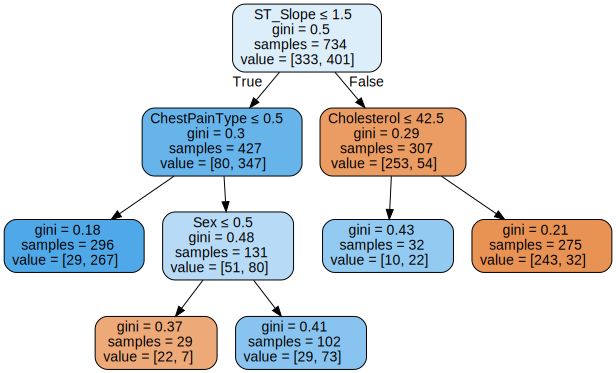

In [19]:
draw_tree(decisionTree, trn_indep)

### Explicando brevemente a imagem da árvore

Cada nó possui no mínino três informações:
* gini: Forma de mensurar quão bom é a divisão. "Qual a probabilidade de entrar nessa amostra pegar um item e então pegar ao pegar outro item ser o mesmo item a cada vez?"
* samples: número de amostras.
* value: como as amostras são agrupadas

## Random Florests (Florestas Aleatórias)

### Uma breve explicação de florestas aleatórias

![](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/random-forest-diagram.svg)

Assim como as Árvores de Decisão as Florestas aleatórias são um tipo de modelo de aprendizado conjunto usado para tarefas de classificação e regressão.

As Florestas Aleatórias são compostas por um grande número de árvores de decisão individuais que são treinadas em diferentes subconjuntos de dados e depois combinadas para fazer previsões.

Para tarefas de classificação como é o caso, a saída da floresta aleatória é a classe selecionada pela maioria das árvores.

Além disso, as florestas aleatórias são capazes de lidar muito bem com grandes conjuntos de dados e dados de alta dimensão.

Para facilitar, vamos criar uma função que gera 1 árvore.

Essa função recebe como parâmetro *prop* (proporção de amostras dos dados de treinamento que serão usadas para treinar a árvore).

No seu corpo ela utiliza a função "random.choice" para selecionar aleatoriamente um número de amostras igual a com tamanho definido pela proporção passada como parâmetro a partir dos dados de treinamento.

Em seguida é criada uma arvóre de decisão, que já foi explicada anteriormente, com os dados obtidos pela escolha aleatória.

In [20]:
def get_tree(prop=0.75):
    idxs = random.choice(len(trn_dep), int(len(trn_dep)*prop))
    
    return DecisionTreeClassifier(min_samples_leaf=10).fit(trn_indep.iloc[idxs], trn_dep.iloc[idxs])

Utilizando um loop para criar 100 árvores e formar a floresta aleatória

In [21]:
florest = [get_tree() for t in range(100)]

Para entender quão boa está a previsão da nossa Foresta aleatória, vamos fazer previsão dos dados de validação para todas as árvores da floresta, obter a média das predições e em seguida calcular o erro absoluto médio entre os valores previstos e os valores reais

In [22]:
from sklearn.metrics import mean_absolute_error

all_probs = [t.predict(val_indep) for t in florest]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_dep, avg_probs)

0.1889130434782609

Obtivemos, cerca de 20% de erro absoluto médio

Uma outra maneira de criar uma floresta aleatória é utilizando a sub-biblioteca sklearn.ensemble, que possui a classe RandomForestClassifier.

Essa classe realiza de maneira otimizada os mesmos passos realizados acima. Devido a sua otimizaçao o erro absoluto médio se mostra menor, portanto é mais preciso.


In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_indep, trn_dep);
mean_absolute_error(val_dep, rf.predict(val_indep))

0.11956521739130435

### Um grande benefício das Arvóres de decissão

Um dos grandes benefícios da árvore de decisão é poder utilizar a propriedade *feature_importances_* para observar a importância de cada variável independente. Quanto maior o valor da propriedade para uma variável independente, maior será sua importancia para perver a variável dependente.

Isso pode auxiliar a filtrar as variáveis independentes, principalmente em casos de tabelas com números exorbitantes de colunas.

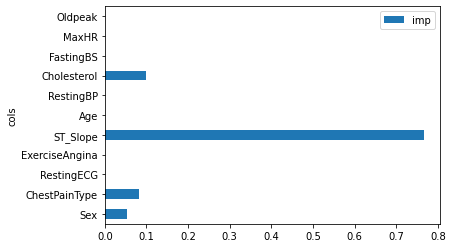

In [24]:
pd.DataFrame(dict(cols=trn_indep.columns, imp=decisionTree.feature_importances_)).plot('cols', 'imp', 'barh');

O gráfico nos mostra que o ST_Slope é, basicamente, o definidor da variável depenedente, pois sua importância é muito superior aos outros dados, além disso a ChestPainType e o Cholestero, támbem se mostraram importantes.

## Deploy

In [25]:
from joblib import dump

dump(florest, 'randomFlorest.joblib')

['rf.joblib']

Exportanto a floresta aleatória para realizar o deploy no [HugginFace](https://huggingface.co/spaces/lucasgbezerra/randomFlorest)
![](https://i.imgur.com/7BqOrGH.png)


### Conclusão

As Florestas aleatórias são uma ótima opção para iniciar, e em alguns casos, podem ser até o passo final, a criação de um modelo, pois além de permitir conhecer melhor o conjunto de dados também auxilia na redução da complexidade do dataset e permite obter resultados simples com uma simplicidade grande.

Em uma situação real onde os dados são massivos, as florestas aleatórias são capazes de lidar muito bem com grandes conjuntos de dados e dados de alta dimensão, além de tarefas de classificação e regressão.

Dependendo da necessidade de precisão, seria possível prever a doença cardíaca apenas observando a ST_Slope. Por exemplo, no caso do artigo, onde a precisão não é o objetivo final, e seu uso é meramente educativo